In [1]:
from d2l import torch as d2l
from torch.nn import functional as F
from torch import nn
import torchvision
import torch
%matplotlib inline


In [2]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:] # 输出最后三层看看样子，会发现倒数两层是不需要的


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [3]:
net = nn.Sequential(*list(pretrained_net.children())[:-2]) # 把最后两层去掉

X = torch.rand(size=(1, 3, 320, 480))
net(X).shape


torch.Size([1, 512, 10, 15])

In [4]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module(
    'transpose_conv', 
    # 图片要放大32倍，所以stride=32。kernel-size和padding要尽量保证图片高宽不变
    # kernel-size取64，让相邻取值会有一些重合
    # 这边可以看一下书
    # 注：转置卷积说不定也可以用插值法来替代（双线性插值等）
    nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, padding=16, stride=32)
)


In [5]:
# 初始化转置卷积层（双线性插值来初始化转置卷积层核的实现）
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (
        torch.arange(kernel_size).reshape(-1, 1),
        torch.arange(kernel_size).reshape(1, -1)
    )
    filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros(
        (in_channels, out_channels, kernel_size, kernel_size)
    )
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight


In [6]:
conv_trans = nn.ConvTranspose2d(
    3, 
    3, 
    kernel_size=4, 
    padding=1, 
    stride=2,
    bias=False
)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4))


tensor([[[[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0

input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


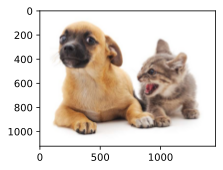

In [8]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('../data/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0))
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img)


In [9]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W)


tensor([[[[0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          ...,
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [10]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)


read 1114 examples
read 1078 examples


loss 0.407, train acc 0.872, test acc 0.838
4.7 examples/sec on [device(type='cuda', index=0)]


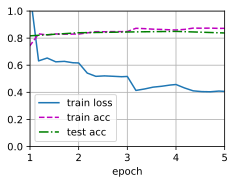

In [11]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)


num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)


In [12]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

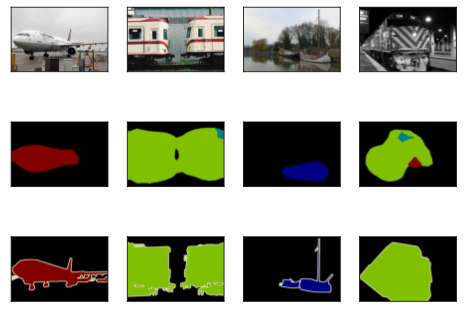

In [13]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]


voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [
        X.permute(1, 2, 0), 
        pred.cpu(),
        torchvision.transforms.functional.crop(
                 test_labels[i], 
                 *crop_rect
        ).permute(1, 2, 0)
    ]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2)
# 丢掉的精度主要是在边缘部分
